# Advanced Lane Detection

#### This Jupyter notebook aims to demostrate Lane Detection using Computer Vision methods explained in Udacity coursework.

In [1]:
## Import all the require modules here
import cv2
import glob
import math
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import HTML
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import center_of_mass
from scipy.signal import find_peaks_cwt, general_gaussian, fftconvolve

from line import Line
import lanefinder

%matplotlib inline
%load_ext autoreload

In [2]:
## Global Variable Definitions

CHESSBOARD_PATTERN_SIZE = (9, 6)
NO_COLS = CHESSBOARD_PATTERN_SIZE[0]
NO_ROWS = CHESSBOARD_PATTERN_SIZE[1]

M     = []  # Camera Matrix
M_INV = []  # Camera Inverse Matrix
DIST  = []  # Distortion co-efficients 

THRESH_GRAY  = (150, 255)  # threshold values for gray scale conversion
THRESH_SCHAN = (200, 255)  # threshold values for S Channel in HLS Space
THRESH_SOBX  = (30, 255)   # threshold values for SobelX filter

## Final
PERSPECTIVE_SRC = np.float32([[580, 460], [710, 460], [1150, 720], [150, 720]]) # perspective source points
PERSPECTIVE_DST = np.float32([[200, 0], [1080, 0], [1080, 720], [200, 720]])  # perspective destionation points


LEFT_LANE  = Line()
RIGHT_LANE = Line()   

## Trial
# PERSPECTIVE_SRC = np.float32([[258, 679], [446, 549], [837, 549], [1045, 679]]) # perspective source points
# PERSPECTIVE_DST = np.float32([[258, 679], [258, 549], [837, 549], [837, 679]])  # perspective destionation points


In [3]:
## Read the given list of images for Camera calibration and Testing, using glob

# retrieve calibration images
images_cal = np.array([plt.imread(i) for i in glob.glob('./camera_cal/calibration*.jpg')])

# retrieve test images
images = np.array([plt.imread(i) for i in glob.glob('./test_images/*.jpg')]) 

image_size = (images[0].shape[1], images[0].shape[0])

print('Calibration Images => ', images_cal.shape)
print('Test Images => ', images.shape)                  

binary_image = None
pers_tranform_binary_image = None

# Define image shape
image_shape = images[0].shape
print("Image shape => ",image_shape)

# Define the region
area_of_interest = [[150+430,460],[1150-440,460],[1150,720],[150,720]]


Calibration Images =>  (20,)
Test Images =>  (8, 720, 1280, 3)
Image shape =>  (720, 1280, 3)


### Camera Calibration

Define a method for Camera calibration using OpenCVs calibrateCamera function. The function calibrateCamera will require an array of object points and the detected corners

In [4]:
def calibrateCamera(images, image_size):

    ## Prepare 3D Object points
    zero3D = np.zeros((CHESSBOARD_PATTERN_SIZE[0]*CHESSBOARD_PATTERN_SIZE[1],3), np.float32)
    zero3D[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane

    # get chessboard corners for all the images
    for idx, img in enumerate(images):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # find chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, CHESSBOARD_PATTERN_SIZE, None)

        # if found, add object points and image points
        if ret == True:
            objpoints.append(zero3D)
            imgpoints.append(corners)

    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)

    return mtx, dist

##### Display Camera Matrix & Distortion Co-efficients

In [5]:
M, DIST = calibrateCamera(images_cal,image_size)

print("Camera Matrix => ")
print(M)

print("Distortion Coefficients => ")
print(DIST)

Camera Matrix => 
[[  1.15662906e+03   0.00000000e+00   6.69041437e+02]
 [  0.00000000e+00   1.15169194e+03   3.88137240e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Distortion Coefficients => 
[[-0.2315715  -0.12000537 -0.00118338  0.00023305  0.15641571]]


##### Method to undistort given images

In [6]:
# method to undistort a given image
def undistort(image, dist_mtx=M, dist_param=DIST):
    return cv2.undistort(image, dist_mtx, dist_param, None, dist_mtx)

##### Test calibrate and distort functions

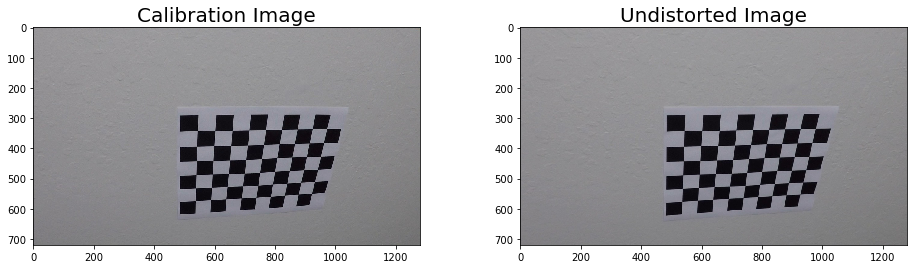

In [7]:
# get a random image for calibration test
rand_cal_test = images_cal[np.random.randint(8)]

fig,(ax1,ax2) = plt.subplots(1, 2, figsize = (16,4))
ax1.imshow(rand_cal_test)
ax1.set_title('Calibration Image',fontsize=20)
ax2.imshow(undistort(rand_cal_test))
ax2.set_title('Undistorted Image',fontsize=20)

## free
rand_cal_test = None

fig.savefig('./output_images/random_camera_calibration_test.png',bbox_inches='tight', pad_inches=0)

### Image Binarization

##### Method to convert a given images into a binary image

* Use color transforms, gradients, etc., to create a thresholded binary image.



This methods applies the following preprocessing algorithms in the specified order
> retrieve S-channel from HLS Space
>
> apply binary threshold on S-channel
>
> compute Sobel X filter on S-channel
>
> apply binary threshold on SobelX
>
> combine both the binary images from above
>
> retrive grayscale image and apply binary threshold
>
> compute bitwise AND between the combined binaries and grayscale binary
    

In [8]:
def binarizeImage(img, threshS=THRESH_SCHAN, threshSX=THRESH_SOBX, threshGray=THRESH_GRAY):
    """ Pipeline for applying image binarization
    
    This methods applies the following preprocessing algorithms in the specified order
    ** retrieve S -channel from HLS Space
    ** apply binary threshold on S -channel
    ** compute Sobel X filter on S -channel
    ** apply binary threshold on SobelX
    ** combine both the binary images from above
    ** retrive grayscale image and apply binary threshold
    ** compute bitwise AND between the combined binaries and grayscale binary
    """
    # pick color channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= threshS[0]) & (s_channel <= threshS[1])] = 1

    # apply Sobel filter with orientation on X-axis
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= threshSX[0]) & (scaled_sobel <= threshSX[1])] = 1

    combined_sobelx_color = np.zeros_like(sxbinary)
    combined_sobelx_color[(s_binary == 1) | (sxbinary == 1)] = 1

    ## binarize a grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    g_binary = np.zeros_like(gray)
    g_binary[(gray >= threshGray[0]) & (gray <= threshGray[1])] = 1

    color_binary = cv2.bitwise_and(combined_sobelx_color, g_binary)

    return color_binary

##### Test binarization method

*Picks up a randome image for further processing below*

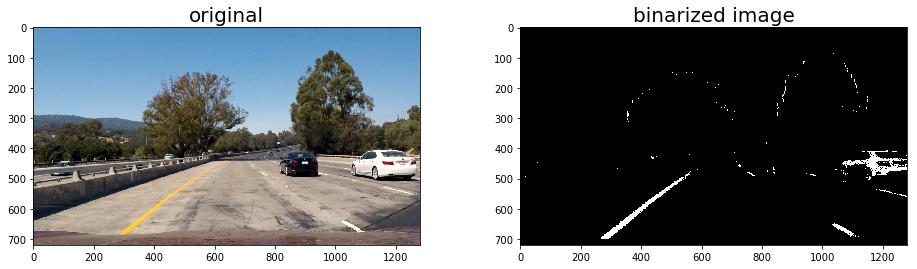

In [9]:
## procedure to test the above method. get a random test image and apply the above method
# use this image in all the below cells for testing.
image = images[np.random.randint(8)]


fig,(ax1,ax2) = plt.subplots(1,2,figsize = (16,4))
ax1.imshow(image)
ax1.set_title('original',fontsize=20)

binary_image = binarizeImage(undistort(image))
ax2.imshow(binary_image, cmap='gray')
ax2.set_title('binarized image',fontsize=20)

fig.savefig('./output_images/random_binarize_image_test.png',bbox_inches='tight', pad_inches=0)

### Perspective Transformation

* Apply a perspective transform to rectify binary image ("birds-eye view").


In [10]:
# gets an input image, and optional source and destination points
def perspectiveTransformation(img, src=PERSPECTIVE_SRC, dst=PERSPECTIVE_DST):
    """ Perform perpective tranformation for a given image
    
    """
    
    img_size = img.shape[:2]
    M     = cv2.getPerspectiveTransform(src, dst)
    M_INV = cv2.getPerspectiveTransform(dst, src)

    warped_img = cv2.warpPerspective(img, M, img_size[::-1], flags=cv2.INTER_LINEAR)

    return warped_img, M, M_INV

##### Test perspective transformation on an Original image and and Undistorted Binary image

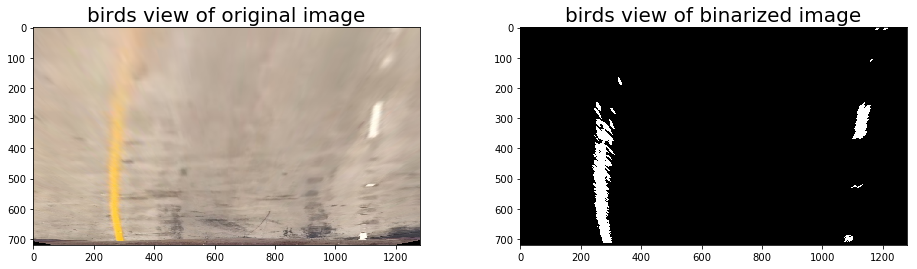

In [11]:
# Test perspective tranformation for both original image and binarized-undistored images
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (16,4))

persImg, m, m1 = perspectiveTransformation(image)
ax1.imshow(persImg)
ax1.set_title('birds view of original image',fontsize=20)

pers_tranform_binary_image, m, m1 = perspectiveTransformation(binary_image)
ax2.imshow(pers_tranform_binary_image, cmap='gray')
ax2.set_title('birds view of binarized image',fontsize=20)

fig.savefig('./output_images/random_perspective_transformation_test.png',bbox_inches='tight', pad_inches=0)

In [12]:
### testing.. remove this

img_size = image.shape[:2]
print(img_size)

print(img_size[::-1])

(720, 1280)
(1280, 720)


## Detect Lane Lines

* Detect lane pixels and fit to find the lane boundary.

> ** From Classroom Notes **
>
> Another way to approach the sliding window method is to apply a convolution, which will maximize the number of "hot" pixels in each window. A convolution is the summation of the product of two separate signals, in our case the window template and the vertical slice of the pixel image.
> 
> You slide your window template across the image from left to right and any overlapping values are summed together, creating the convolved signal. The peak of the convolved signal is where there was the highest overlap of pixels and the most likely position for the lane marker.

##### Perform a sliding window search using Convolution method 
>>> **NOT USED** for the final video processing pipleine, source code taken from Classroom Quiz

* Using the last two window lines to find the first centroid point, instead of the complete bottom quarter

In [13]:
## Citation: From Classroom Quiz

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(7*warped.shape[0]/9):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(7*warped.shape[0]/9):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index+offset ## Modified to + 
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
    
    return window_centroids


def window_fitting_lanes(img, window_width=50, window_height=60, margin=50):

    # window settings
    # window_width  = 50 # width of the sliding window 
    # window_height = 60 # Break image into 11 vertical layers since image height is 720 (=720/60)
    # margin        = 50 # How much to slide left and right for searching

    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    left_x_PTF  = []
    left_y_PTF  = []
    right_x_PTF = []
    right_y_PTF = []
    
    # If we found any window centers
    if len(window_centroids) > 0:
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
            
            # points to fit 
            left_x_PTF.append(window_centroids[level][0])
            left_y_PTF.append(level*window_height)
            right_x_PTF.append(window_centroids[level][1])
            right_y_PTF.append(level*window_height)


        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
        
    return output, left_x_PTF, left_y_PTF, right_x_PTF, right_y_PTF

##### Test Window Fitting Lane Fuction Using Convolution
Display a green blocks of windows over the estimated/detected lane.

**NOT Working as expected. So using the histogram based approach for the final pipeline**

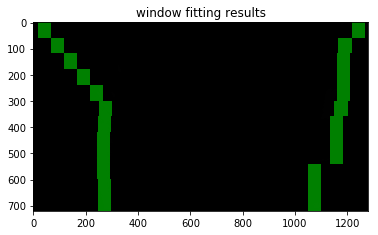

In [14]:
# Read in a thresholded image
warped = pers_tranform_binary_image ## binary_image  ## mpimg.imread('warped_example.jpg')

output, left_x_PTF, left_y_PTF, right_x_PTF, right_y_PTF = window_fitting_lanes(warped)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

## Image Processing Pipeline

##### Define methods used for the processing in the pipeline

In [15]:
def radiusOfCurvature(yValues, fitx):
    """ Calculate radius of curvature
    
    """

    ## define pixel convertions to meter unit
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700

    # calculate radius of curvature
    y_eval = np.max(yValues)
    fit_cr = np.polyfit(yValues*ym_per_pix, fitx*xm_per_pix, 2)
    radius = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*fit_cr[0])
    return radius

def getVehiclePosition(pts):
    """ Calculate the position of the car from the center of the lane 
    
    """

    # assume the car is in the center
    position = image_shape[1]/2
    leftArr = pts[(pts[:,1] < position) & (pts[:,0] > 600)][:,1]
    rightArr = pts[(pts[:,1] > position) & (pts[:,0] > 600)][:,1]
    
    # calculate deviation
    if(len(leftArr) > 0 & len(rightArr) > 0):
        left  = np.min(leftArr)
        right = np.max(rightArr)  
        center = (left + right)/2
    else:
        center = 0
    
    # pixel-meter conversion
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension    
    
    return (position - center)*xm_per_pix

In [16]:
def laneFitter(image, left_lane, right_lane):
    """ Fit lanes based on the window searching
    
    Find lanes with three different masks on the bottom portion of the image 
    and fit a polynomial based on the search results
    
    """

    # we may need to calculate X-values based on Y.
    # pick y-values for the entire height of the image
    yValues = np.linspace(0, 100, num=101)*7.2
    
    # coordinates for left & right lanes
    lanes = np.argwhere(image)
    lefLnX = []
    leftLnY = []
    rightLnX = []
    rightLnY = []

    # Curving left or right - -1: left 1: right
    curve = 0

    # Set left and right as None
    left = None
    right = None

    # Find lanes from three repeated procedures with different window values
    lefLnX, leftLnY, rightLnX, rightLnY = lanefinder.findLanes(4, image, 25, lanes, lefLnX, leftLnY, rightLnX, rightLnY, 0, left_lane, right_lane)
    lefLnX, leftLnY, rightLnX, rightLnY = lanefinder.findLanes(6, image, 50, lanes, lefLnX, leftLnY, rightLnX, rightLnY, 1, left_lane, right_lane)
    lefLnX, leftLnY, rightLnX, rightLnY = lanefinder.findLanes(8, image, 75, lanes, lefLnX, leftLnY, rightLnX, rightLnY, 2, left_lane, right_lane)

    # computer coefficients for the polynomial
    leftFit = np.polyfit(leftLnY, lefLnX, 2)
    leftFitX = leftFit[0]*yValues**2 + leftFit[1]*yValues + leftFit[2]
    rightFit = np.polyfit(rightLnY, rightLnX, 2)
    rightFitX = rightFit[0]*yValues**2 + rightFit[1]*yValues + rightFit[2]

    # get radius of curvature
    left_curverad  = radiusOfCurvature(yValues, leftFitX)
    right_curverad = radiusOfCurvature(yValues, rightFitX)
    
    # validate lanes' fit
    leftFitX  = lanefinder.doValidateLanes(left_lane, left_curverad, leftFitX, leftFit)
    rightFitX = lanefinder.doValidateLanes(right_lane, right_curverad, rightFitX, rightFit)
    
    return yValues, leftFitX, rightFitX, lefLnX, leftLnY, rightLnX, rightLnY, left_curverad

### Function to Draw Overlay

This function draws the final overlay on the image

In [17]:

def drawOverlay(image, warped, yValues, leftFitX, rightFitX, 
              lefLnX, leftLnY, rightLnX, rightLnY, inv_M, curvature):

    """ Draw an overlay on the predicted lanes 
    
    """
    
    # overlay template
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # stack left lane & right lane together
    pt_left = np.array([np.transpose(np.vstack([leftFitX, yValues]))])
    pt_right = np.array([np.flipud(np.transpose(np.vstack([rightFitX, yValues])))])
    pts = np.hstack((pt_left, pt_right))
    
    # draw lanes onto the template - in green color
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 200, 0))
    newwarp = cv2.warpPerspective(color_warp, inv_M, (image.shape[1], image.shape[0])) 
    
    # apply overlay
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    # add caption
    text = "Radius of Curvature: {:.2f} km".format(curvature/1000)
    cv2.putText(result,text,(100,100), 1, 1,(255,255,255),2)
    
    # find the poisition of the car with respect to lane center
    pts = np.argwhere(newwarp[:,:,1])
    position = getVehiclePosition(pts)
    
    if position < 0:
        text = "Vehicle is {:.2f} m left of lane center".format(-position)
    else:
        text = "Vehicle is {:.2f} m right of lane center".format(position)
    
    cv2.putText(result,text,(100,150), 1, 1,(255,255,255),2)

    return result

##### This function combines the above methods and forms a pipeline

In [18]:
# This function will color the image
# Input: Original image
# Output: Original image with colored region
def process_image(image, left_lane=LEFT_LANE, right_lane=RIGHT_LANE):
    # Apply pipeline to the image to create black and white image

    img = binarizeImage(undistort(image))
    
    # Warp the image to make lanes parallel to each other
    top_down, M, M_INV = perspectiveTransformation(img)

    # Find the lines fitting to left and right lanes
    # Set up lines for left and right
    yValues, leftFitX, rightFitX, lx, ly, rx, ry, curvature = laneFitter(top_down, left_lane, right_lane)
    
    # Return the original image with colored region
    return drawOverlay(image, top_down, yValues, leftFitX, rightFitX, lx, ly, rx, ry, M_INV, curvature)

##### Test the pipeline

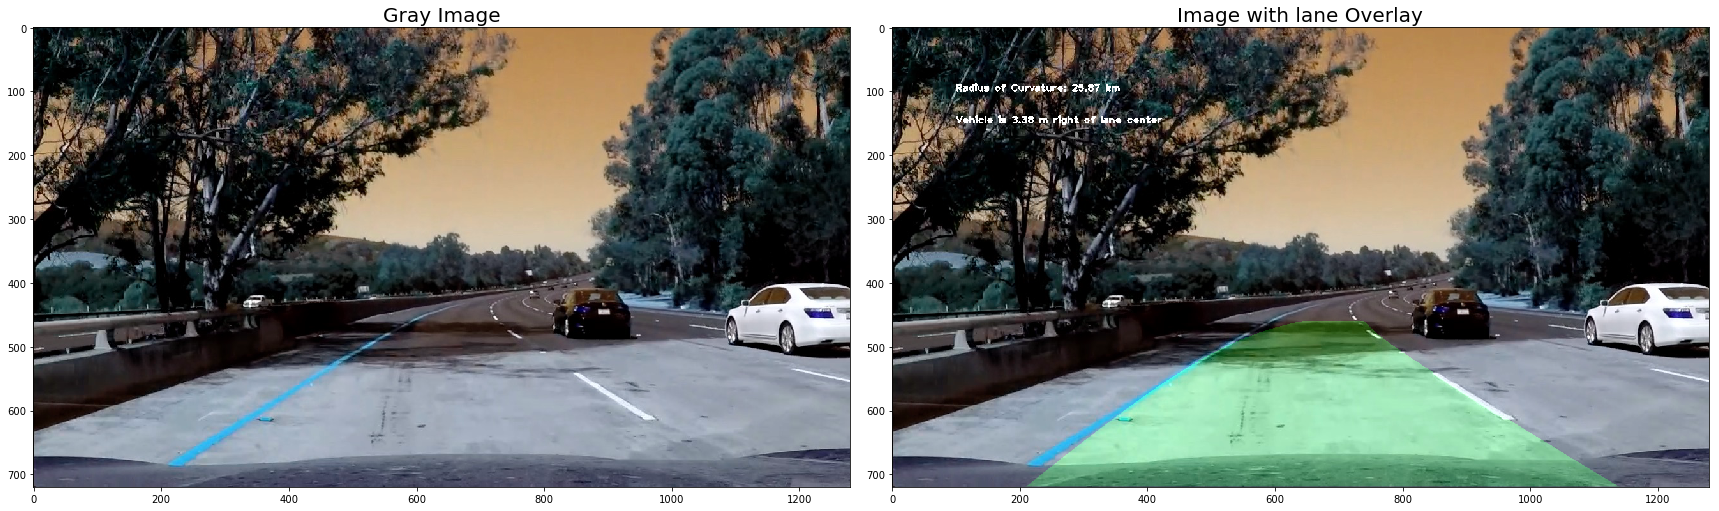

In [19]:
fname = 'test_images/test5.jpg'
img_raw = cv2.imread(fname)

left_lane = Line()
right_lane = Line()    

img = process_image(img_raw, left_lane, right_lane)

# Set up for the subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
# Showing the image from pipeline with marked areas
ax1.set_title('Gray Image', fontsize=20)
ax1.imshow(img_raw)

ax2.imshow(img)
ax2.set_title('Image with lane Overlay', fontsize=20)

f.savefig('./output_images/test_pipeline.png',bbox_inches='tight', pad_inches=0)

##### Process the input video using the above pipeline and store

In [20]:

from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Set up lines for left and right
left_lane = Line()
right_lane = Line()
white_output = 'output_project_video.mp4'

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████▉| 1260/1261 [06:31<00:00,  3.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

CPU times: user 19min 53s, sys: 1min 5s, total: 20min 58s
Wall time: 6min 32s


##### Apply the above processing pipeline on the give test_messages, draw overlay and save.

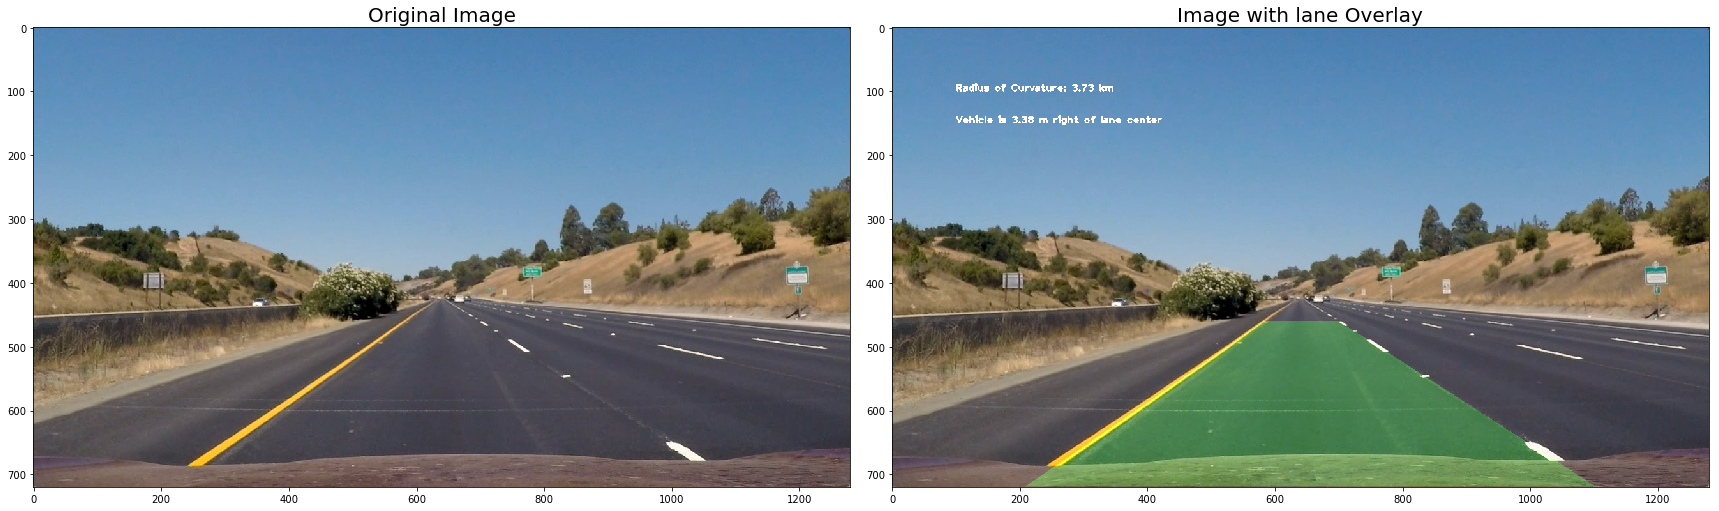

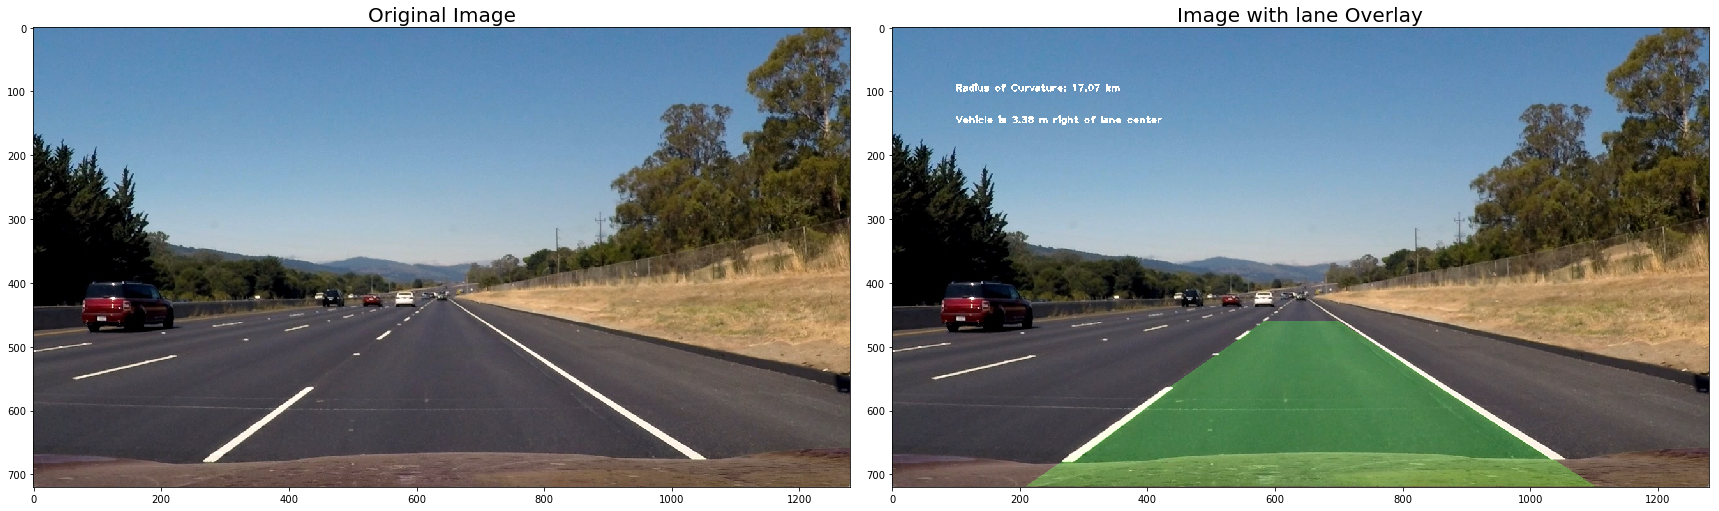

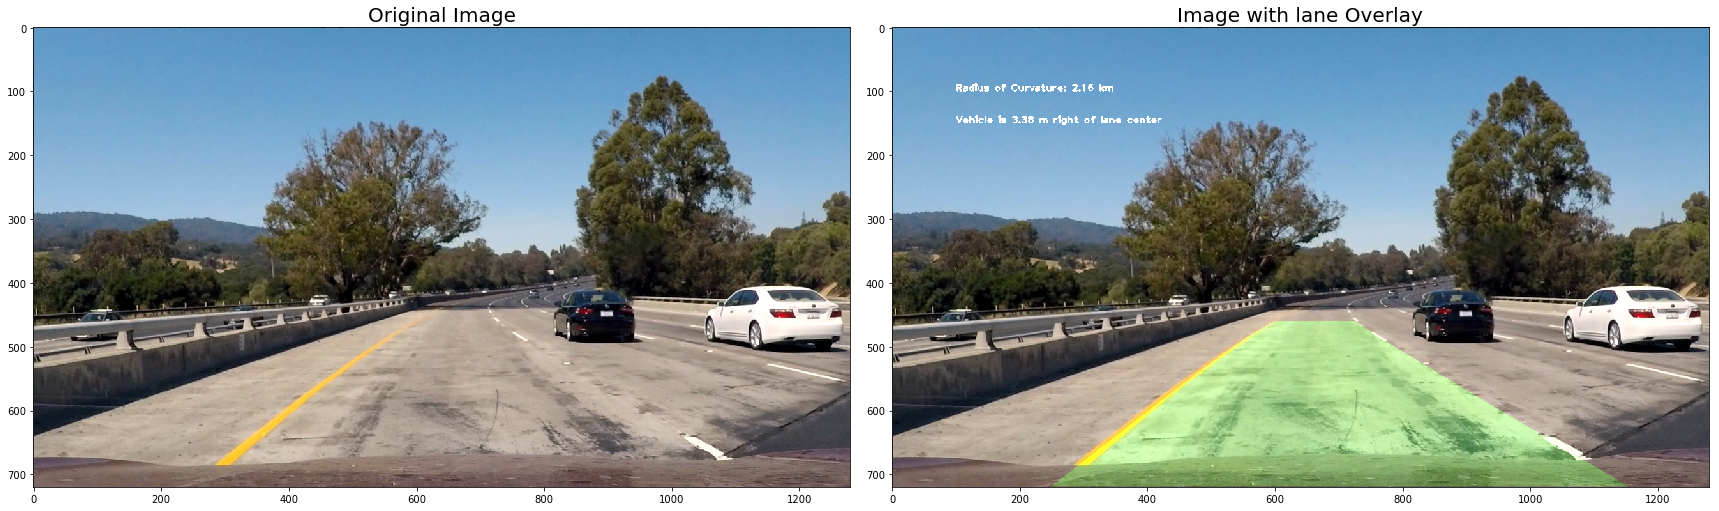

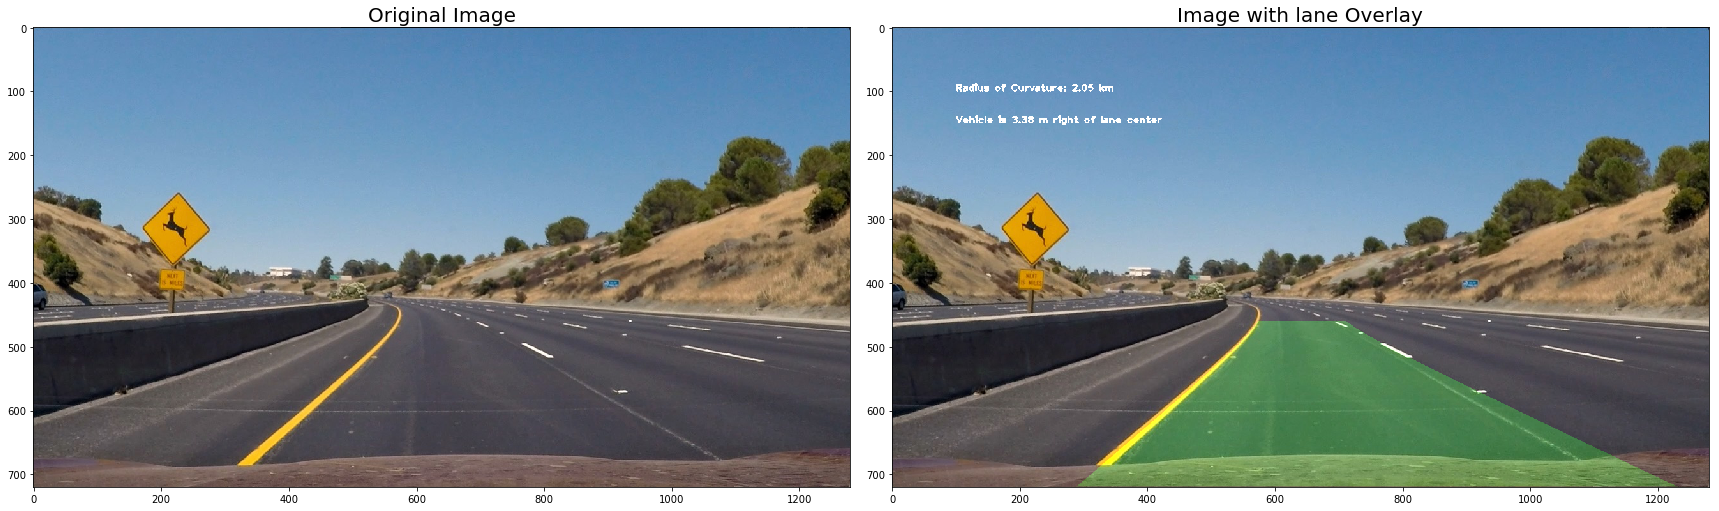

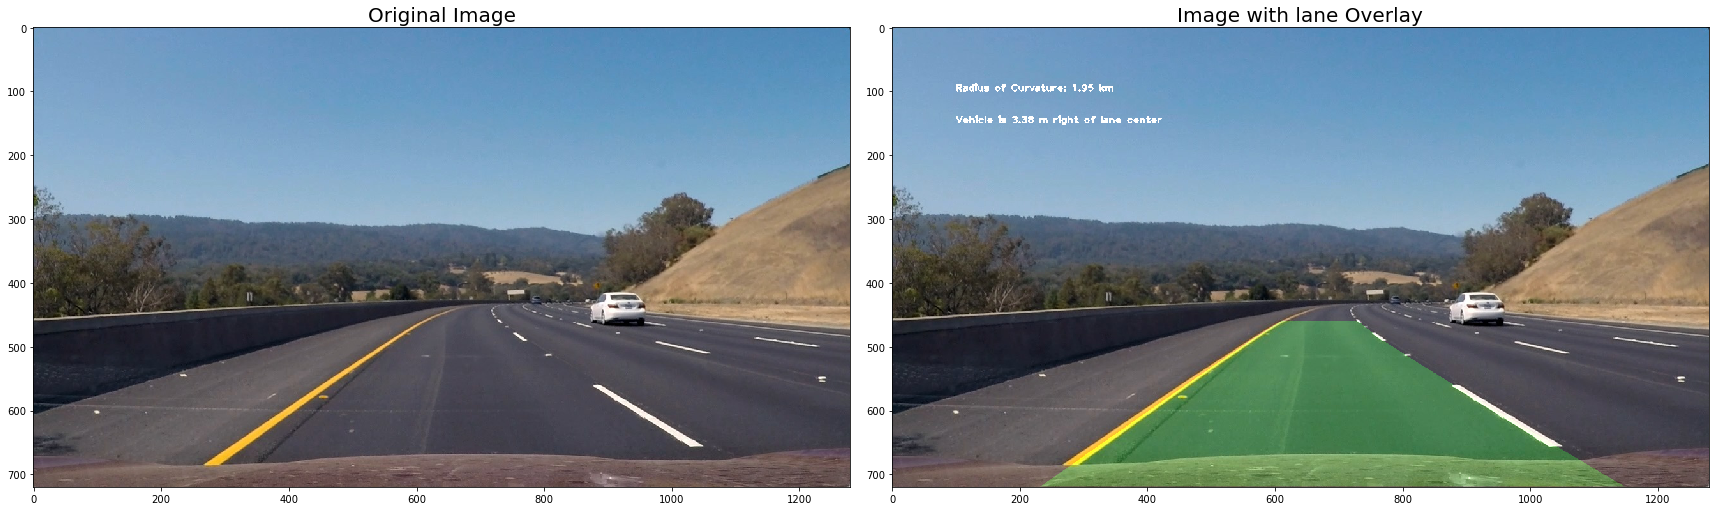

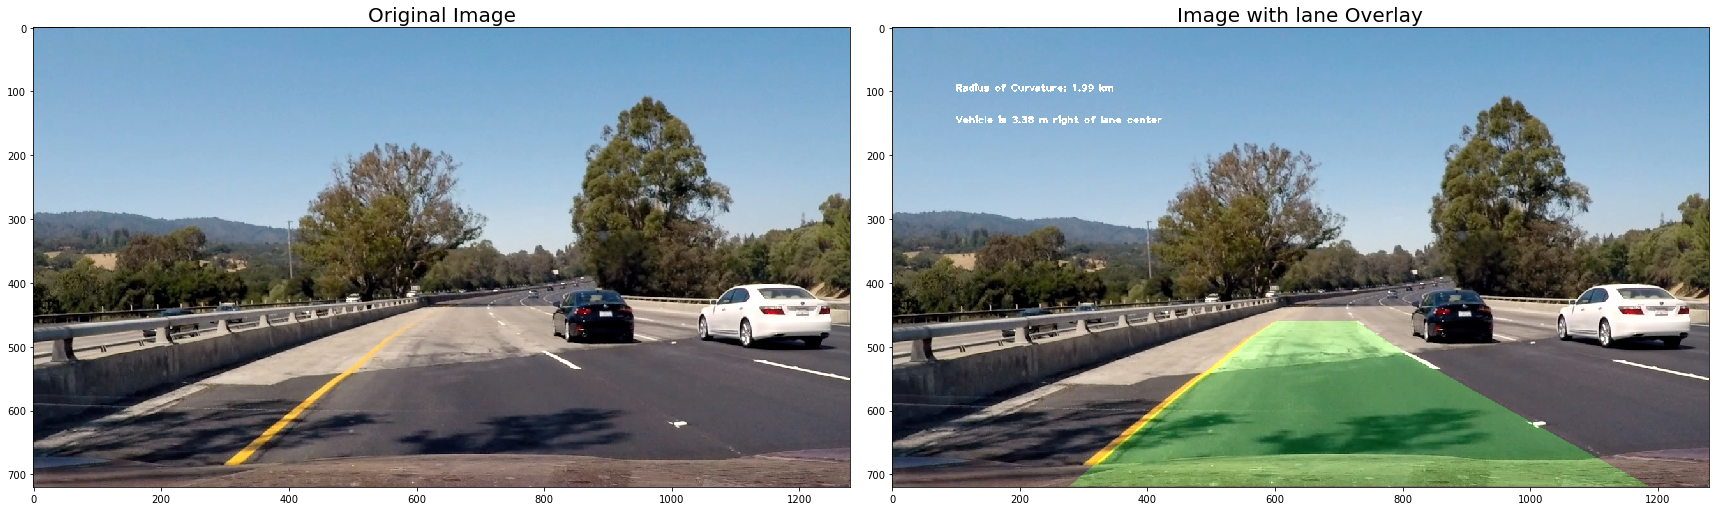

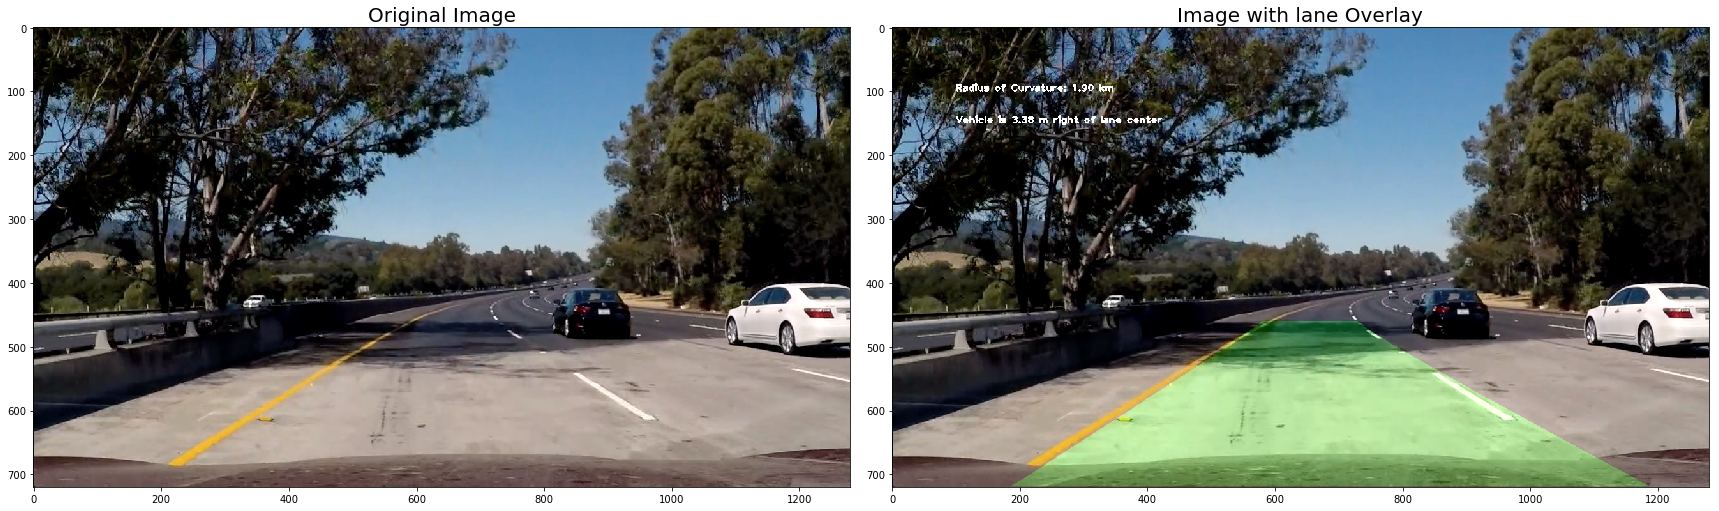

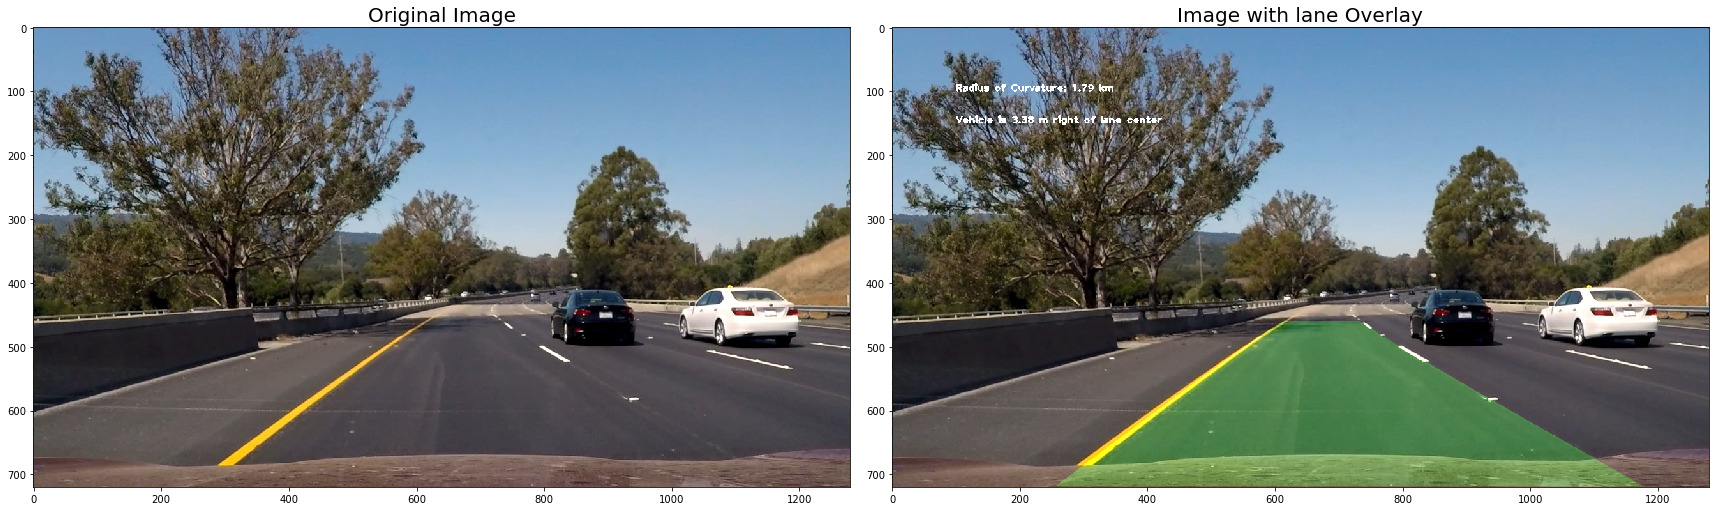

In [21]:
## Loop through the test images and create results in output_images folder.

for idx, image in enumerate(images, start=1):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    fig.tight_layout()
    
    ax1.set_title('Original Image', fontsize=20)
    ax1.imshow(image)

    ax2.imshow(process_image(image, left_lane, right_lane))
    ax2.set_title('Image with lane Overlay', fontsize=20)
    
    fig.savefig('./output_images/output_' + str(idx) + ".png",bbox_inches='tight', pad_inches=0)

### The End.